# Analysis of FastMap Algorithm on Directed Graph

The content of this analysis includes:

1. Dataset - testing graph:
    - Generated random graph
    - Some directed networks from [Stanford Large Network Dataset Collection (SNAP)](https://snap.stanford.edu/data/)
2. Variant of FastMap on directed graph:
    - Two embeddings:
        1. $h_1(i, j)=\frac{d_{ij}+d_{ji}}{2}$
        2. $h_2(i, j)=\frac{|d_{ij}-d_{ji}|}{2}$
    - Part accurate distances: a byproduct, every nodes' distances with some pivot nodes
3. Evaluation:
    - Precision of picking the bigger one of $d_{ij}$ and $d_{ji}$, using stroed distances
    - Distortion of embedding:
        1. Using real comparation result of $d_{ij}$ and $d_{ji}$, then $h(i,j)=h_1(i, j)\pm h_2(i, j)$
        2. Using prediction of comparation result of $d_{ij}$ and $d_{ji}$, then $h(i,j)=h_1(i, j)\pm h_2(i, j)$
        3. Using stroed distances to fine-tune heuristic value from embedding.
4. Experiments and results

In [12]:
# Add libraries
%load_ext autoreload
%autoreload 2
import os, sys
lib_path = os.path.abspath(os.path.join('../heuristic/'))
sys.path.append(lib_path)

import fastmap.utils as utils
from fastmap.difastmap import init_dis_store, difastmap_average, difastmap_diff 
import fastmap.analyse as analyse

import matplotlib.pyplot as plt
import networkx as nx
import random
import multiprocessing as mp
from random import sample

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate random testing graph:

1. `generate_random_digraph(n, p, low, high)`: generate a directed graph with `n` nodes, and every edge have positive weith range in `[low, high]`, it make sure the graph is strongly connected, otherwise there is a warning for increasing `p` (the probability of an directed edge exist between two nodes). Density $D = \frac{|E|}{|V|(|V|-1)}$ is also printed.

2. `distance_info(G)`: show the distribution of distances between nodes.

An example:

Density: 0.006936936936936937


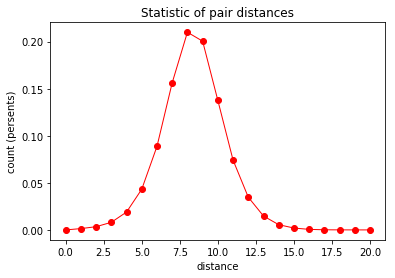

In [13]:
n = 1000
p = 0.007
low = 1
high = 5

G, density = utils.generate_random_digraph(n, p, low, high)
utils.distance_info(G)

## Variant algorithms of embedding

![Figure](alg-fastmap.png)

1. `init_dis_store()`: init the data structure to store every nodes' distances to pivot nodes, the store process will be finish while doing the embedding.

2. `difastmap_average(G, K, epsilon, dis_store, alg='L1')`: used to get the embedding of average distances.

3. `difastmap_diff(G, K, epsilon, dis_store, alg='L1')`: used to get the embedding of absolute difference of distance.

An example:

In [14]:
K = 20
epsilon = 0.01
alg = 'L2'
dis_store = init_dis_store(G)
embedding_aver = difastmap_average(G, K, epsilon, dis_store, alg)
embedding_diff = difastmap_diff(G, K, epsilon, dis_store, alg)
S = 1
subset = random.sample(list(G.nodes()), S)
for i in subset:
    print("Node {}:\n{}\n{}".format(i, embedding_aver[i], embedding_diff[i]))

Node 584:
[6.137931034482759, 8.072245669456558, 7.017792183010349, 5.915087287454047, 6.488457712965836, 6.404585052666489, 5.508267374400154, 6.750216687536121, 4.315351520691282, 7.656042045085046, 4.669826850302655, 5.724544907422509, 4.816724836661969, 6.266607795246967, 6.501232603486956, 4.996439801868418, 6.268492801065082, 5.49431527393524, 6.788118911363188, 3.7520084913847094]
[2.8958333333333335, 2.0156916782879253, 3.251876875790709, 2.1611997323918284, 3.037708425066985, 2.2206555914968513, 2.249813522950724, 3.14573474649297, 1.4434390286727965, 2.1376471528783787, 2.9811751029389524, 2.024512405779397, 2.1188023796089386, 2.270537725849048, 2.5554440602072583, 2.9996155279677637, 2.341334286476193, 2.3263365119004, 2.02141584205973, 2.2297494147779138]


## Evaluation functions

`dinrmsd(G, embedding_aver, embedding_diff, dis_store, S, alg = 'L1')`: the function for evaluate the performance of the heuristic. `S` is the number of subset choosed for evaluation, and the `alg` should be set as the one used in FastMap embedding.

The output has four value:

- Precision of comparing $d_{ij}$, $d_{ji}$
- Distortion when:
    - Real comparision
    - Predicted comparision
    - Fine-tuned distance
    
Using the Normalized Root Mean Square Deviation (NRMSD):
$$\sigma = \sqrt{\frac{\sum_{1\le i < j\le S}{(d_{ij}-x_{ij})^2}}{S(S-1)}}$$
$$\bar{d}=\frac{\sum_{1\le i < j\le S}{d_{ij}}}{S(S-1)}$$

In [34]:
S = int(0.2*len(list(G.nodes())))
results = analyse.dinrmsd(G, embedding_aver, embedding_diff,dis_store, S, alg)
print("\nPrecision: "+str(results[0]))
print("Distortion_real: "+ str(results[1]))
print("Distortion_pred: "+ str(results[2]))
print("Distortion_tune: "+ str(results[3]))

Analysis Process: 0.0%
Precision: 0.7421052631578947
Distortion_real: 0.2775127004423273
Distortion_pred: 0.32448200134466887
Distortion_tune: 0.25130986069654365


## Experiments

There are three kinds of experiments:

1. How distortions changes with different `K`, the demention of embedding
2. Try multiple times on simulated network to get average evalution results.
3. Try test on real datasets.

In [ ]:
# Test K     
n = 1000
p = 0.007
low = 1
high = 5

G,density = generate_random_digraph(n, p, low, high)
distance_info(G)

k_list = [10, 15, 20,25,30,35,40,45,50]
all_result = {}
for K in k_list:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding_aver = difastmap_average(G, K, epsilon, dis_store, alg)
    embedding_diff = difastmap_diff(G, K, epsilon, dis_store, alg)
    S = int(0.2*len(list(G.nodes())))
    subset = sample(list(G.nodes()), S)
    results = dinrmsd_mp(G, embedding_aver, embedding_diff,dis_store, subset, alg)
    print("\nPrecision: "+str(results[0]))
    print("Distortion_real: "+ str(results[1]))
    print("Distortion_pred: "+ str(results[2]))
    print("Distortion_tune: "+ str(results[3]))
    results = list(results)
    results.append(density)
    print("Density: "+str(density))
    name = 'Ktest-'+str(K)
    all_result[name] = results

In [ ]:
# Test for more simulated datasets to get average:
K = 20
for r in range(5):
    print("#########Test for toy dataset, round:{}".format(r))
    G, density = generate_random_digraph(n, p, low, high)
    epsilon = 0.01
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding_aver = difastmap_average(G, K, epsilon, dis_store, alg)
    embedding_diff = difastmap_diff(G, K, epsilon, dis_store, alg)
    S = int(0.2*len(list(G.nodes())))
    subset = sample(list(G.nodes()), S)
    results = dinrmsd_mp(G, embedding_aver, embedding_diff,dis_store, subset, alg)
    print("\nPrecision: "+str(results[0]))
    print("Distortion_real: "+ str(results[1]))
    print("Distortion_pred: "+ str(results[2]))
    print("Distortion_tune: "+ str(results[3]))
    results = list(results)
    results.append(density)
    print("Density: "+str(density))
    name = 'Round-'+str(r)
    all_result[name] = results

In [ ]:
# Test for real sets:
K = 30
in_directory = "../data/snap/"
files= os.listdir(in_directory)
for file in files:
    if not os.path.isdir(file) and file[0:3]=='p2p':
        print("#########Test for real dataset:{}".format(file))
        name = file
        G = utils.readDiGraph(in_directory+name)
        n = len(list(G.nodes()))
        density = float(len(G.edges()))/(n*(n-1))
        epsilon = 0.01
        alg = 'L2'
        dis_store = init_dis_store(G)
        embedding_aver = difastmap_average(G, K, epsilon, dis_store, alg)
        embedding_diff = difastmap_diff(G, K, epsilon, dis_store, alg)
        S = int(0.2*len(list(G.nodes())))
        if S > 400:
            S = 400
        subset = sample(list(G.nodes()), S)
        results = dinrmsd_mp(G, embedding_aver, embedding_diff,dis_store, subset, alg)
        print("\nPrecision: "+str(results[0]))
        print("Distortion_real: "+ str(results[1]))
        print("Distortion_pred: "+ str(results[2]))
        print("Distortion_tune: "+ str(results[3]))
        results = list(results)
        results.append(density)
        print("Density: "+str(density))
        name = 'Real-'+str(name)
        all_result[name] = results

### Using multi-processing to speed up analysis

Because it's very time cosuming on the analysing process, so I add multi-processing on it. And put it on Google Cloud Platform to do run the experiment.

An simple example for using the multi-processing version.

In [ ]:
"""
S = int(0.2*len(list(G.nodes())))
subset = sample(list(G.nodes()), S)
results = dinrmsd_mp(G, embedding_aver, embedding_diff,dis_store, subset, alg)
print("\nPrecision: "+str(results[0]))
print("Distortion_real: "+ str(results[1]))
print("Distortion_pred: "+ str(results[2]))
print("Distortion_tune: "+ str(results[3]))
"""

In [18]:
%%bash
python mp_example.py

Density: 0.00700800800801
Pool size: 8

Precision: 0.702412060302
Distortion_real: 0.314788688477
Distortion_pred: 0.379831831446
Distortion_tune: 0.273899519868


The experiment code includes in `mp_experiment1.py`: it is runnable

In [ ]:
%%bash
python mp_experiment.py

### Result:

Recap the meaning of the measurement:

- Precision of picking the bigger one of $d_{ij}$ and $d_{ji}$, using stroed distances
- Distortion of the heuristic:
    1. Using real comparation result of $d_{ij}$ and $d_{ji}$, then $h(i,j)=h_1(i, j)\pm h_2(i, j)$
    2. Using prediction of comparation result of $d_{ij}$ and $d_{ji}$, then $h(i,j)=h_1(i, j)\pm h_2(i, j)$
    3. Using stroed distances to fine-tune heuristic value from embedding.

|    K          |  10  |  15  |  20  |  25  |  35  |  40  |  45  |  50  |
|---------------|------|------|------|------|------|------|------|------|
|Precision      |0.6598|0.6990|0.7062|0.7236|0.7481|0.7363|0.7356|**0.7875**|
|Real-distortion|0.4698|0.3418|**0.2748**|0.3123|0.3917|0.9653|0.9219|1.003 |
|Pred-distortion|0.5042|0.3870|**0.3316**|0.3676|0.4330|0.9837|0.9475|1.028 |
|Tune-distortion|0.3105|**0.2387**|0.2467|0.2882|0.3168|0.2675|0.3062|0.2471|

In this table, the origin graph is same, a generated graph with $|G.nodes()| = 1000$, and $Density(G)=0.0071$. The density is almost at the edge of keep the graph strongly connected.

Some conclusion about the dimension $K$:

- The precision of comparing $d_{ij}, d_{ji}$ increase with $K$, the can be a result of more stored distances with pivot nodes.
- The tune-distortion is stable with the increasement of $K$, while the distortion of heuristic value from embedding distance will be very large if $K$ is too big. (Increase $\epsilon$ can avoid this situation.)


|               |  Nodes  |  Density  |  K  |  Precision  |  Real-distortion  |  Pred-distortion  |  Tune-distortion  |
|---------------|------|------|------|------|------|------|------|
| Ramdom Graph  |1000  |0.0070|20|0.7232|0.2910|0.3525|**0.2673**|
| RealGraph-1   |3234  |0.0012|30|0.7563|0.4558|0.5059|**0.3890**|
| RealGraph-2   |3226  |0.0013|30|0.7433|0.3717|0.4295|**0.3831**|
| RealGraph-3   |2068  |0.0021|30|0.7421|0.4101|0.4662|**0.3654**|
| RealGraph-4   |2624  |0.0015|30|0.7737|0.4519|0.5020|**0.3167**|

In this table, all real graph is extracted strongly connected component of directed graph, [internet peer-to-peer networks](https://snap.stanford.edu/data/p2p-Gnutella05.html), given uniform edge weights.

The conclusion is:

- The fine-tuned heuristic value is closest to real distance.